## Q1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

读入数据，进行清洗，首先去除可能存在nan或重复的行

In [4]:
original_data = pd.read_csv('HotPotForMac.csv')

In [5]:
cleaned_data = original_data.dropna()
cleaned_data = cleaned_data.drop_duplicates()

In [6]:
cleaned_data.shape

(2688, 27)

销量为0的团购在取对数之后会变成负无穷，影响统计，考虑到销量为0的团购在数据中占比不多，因此也去除掉

In [8]:
cleaned_data = original_data
cleaned_data = cleaned_data[cleaned_data['quarterly.sales.volume'] != 0].copy()
cleaned_data['quarterly.sales.volume.log'] = np.log(cleaned_data['quarterly.sales.volume'])

In [9]:
cleaned_data.shape

(2412, 28)

## Q2

开始分别绘制季均销量、团购上线天数、折扣力度的分布直方图

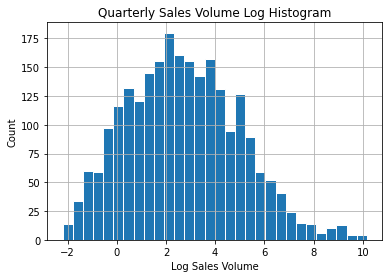

In [10]:
plt.hist(cleaned_data['quarterly.sales.volume.log'], bins=30, edgecolor='white')

# 添加标题和标签
plt.grid()
plt.title('Quarterly Sales Volume Log Histogram')
plt.xlabel('Log Sales Volume')
plt.ylabel('Count')

# 显示图形
plt.show()

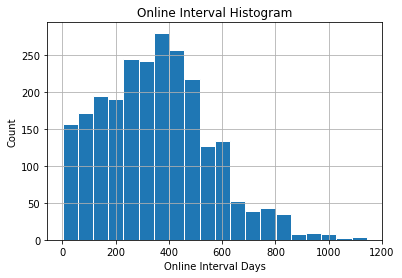

In [11]:
plt.hist(cleaned_data['online.intervel'], bins=20, edgecolor='white')

# 添加标题和标签
plt.grid()
plt.title('Online Interval Histogram')
plt.xlabel('Online Interval Days')
plt.ylabel('Count')

# 显示图形
plt.show()

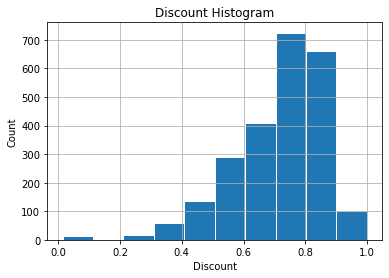

In [12]:
plt.hist(cleaned_data['discount'], bins=10, edgecolor='white')

# 添加标题和标签
plt.grid()
plt.title('Discount Histogram')
plt.xlabel('Discount')
plt.ylabel('Count')

# 显示图形
plt.show()

从对数季均销量直方图来看，销量数据呈现右偏分布，平均对数销量为2.68，中位数对数销量为2.55，说明少数畅销团购拉高了平均水平。最高对数销量为10.16，最低为-2.2

从团购上线天数直方图来看，上线天数平均值为350，中位数为344，上线时间较短的团购数目多，猜测可能是对于上线时间太长的团购，感兴趣顾客已经消费过，不感兴趣的顾客也不会选购

从折扣力度直方图来看，数据呈现左偏分布，平均值为0.72，中位数为0.76，大部分团购打折力度在0.7-0.9，说明少数大力度打折团购拉低了平均水平，也可猜测0.7-0.9对商家来说是既能提高销量又能保证利润的合理区间，力度太低容易亏本，力度太高吸引不到顾客

## Q3

接下来统计店名高频词，生成词云图。首先通过正则表达式去除英文、数字，并去除“路”、“火锅”、“小区”这样的无意义词组，然后调用.value_counts()方法做词频统计

In [205]:
import re
# 创建一个正则表达式，匹配非中文字符和一些无意义的词 
pattern = re.compile(r'[a-zA-Z0-9]+|区|路|火锅|小区|街道|市场|店|老火锅|焖锅|\([^)]*\)')
cleaned_name = cleaned_data['字段1'].apply(lambda x: re.sub(pattern, '', x))
cleaned_name.value_counts()

重庆鸡公煲      54
七婆串串香      38
小芭蕉泰式      27
鸭掌门特色      23
食色         22
           ..
流氓串串        1
洋芋糍粑        1
大秦串串        1
火翻天土鸡       1
有甜有闲私房菜     1
Name: 字段1, Length: 942, dtype: int64

发现“重庆鸡公煲”、“七婆串串香”、“小芭蕉泰式”、“鸭掌门特色”等几个词的频数很高，猜测可能存在一些连锁店，也可能是鸡公煲、串串香、泰式火锅等是比较受消费者青睐的菜品，因此很多商家以此为主打菜，放在店名中

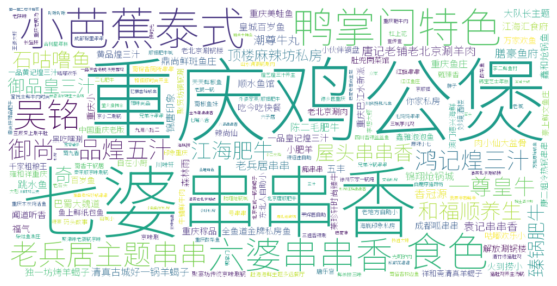

In [207]:
# 构建词云图
word_dict = cleaned_name.value_counts().to_dict()
wordcloud = WordCloud(background_color="white", font_path='SourceHanSansSC-VF.ttf', width=1000, height=500).generate_from_frequencies(word_dict)

# 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Q4
首先根据价格高低进行划分，这里采用平均值作为低价团购和高价团购的划分标准

In [208]:
cleaned_data['price'].describe()

count    2412.000000
mean      109.798483
std        85.043964
min         1.000000
25%        68.000000
50%        88.000000
75%       135.250000
max      1365.000000
Name: price, dtype: float64

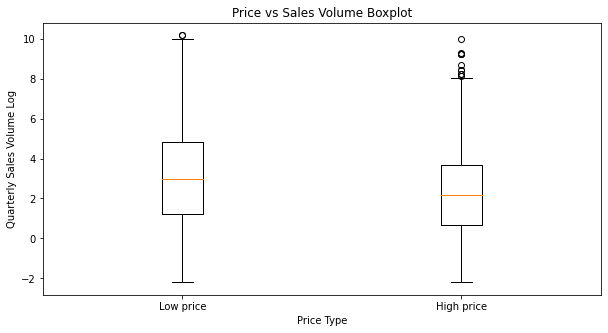

In [22]:
low_price = cleaned_data[cleaned_data['price'] <= 88]['quarterly.sales.volume.log']
high_price = cleaned_data[cleaned_data['price'] > 88]['quarterly.sales.volume.log'] 

plt.figure(figsize=(10, 5))
plt.boxplot([low_price, high_price], labels=['Low price', 'High price'])

plt.xlabel('Price Type')
plt.ylabel('Quarterly Sales Volume Log')

plt.title('Price vs Sales Volume Boxplot')
plt.show()

从图中可见，低价团购的对数销量平均水平（中位数）要高于高价团购，说明低价团购可能更受消费者欢迎。低价团购的箱子位置更高，也即销量大，可能是顾客对价格敏感，更倾向于选择便宜的团购。

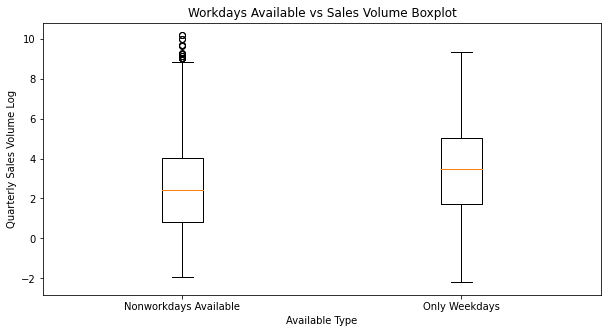

In [23]:
bool_index = cleaned_data['if.nonworkdays.available'].str.contains('非')
used_all_days = cleaned_data[bool_index == False]['quarterly.sales.volume.log']
only_weekdays = cleaned_data[bool_index]['quarterly.sales.volume.log'] 

plt.figure(figsize=(10, 5))
plt.boxplot([used_all_days, only_weekdays], labels=['Nonworkdays Available', 'Only Weekdays'])

plt.xlabel('Available Type')
plt.ylabel('Quarterly Sales Volume Log')

plt.title('Workdays Available vs Sales Volume Boxplot')
plt.show()

可以看出，仅工作日可用的销量平均水平（中位数）更高，整体上销量也更好，可能是因为工作日的消费者购买力更高，例如，一些人可能在工作日更忙碌，没有时间煮饭或外出吃饭，因此更愿意购买团购餐饮服务。也可能由于节假日的团购促销活动通常更多，商家之间的竞争也更激烈，导致了销量分散

## Q5

这部分选取了出现次数最高的前三个词绘制箱线图

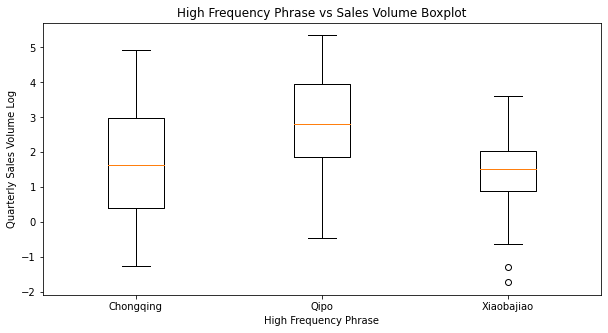

In [24]:
chongqing_bool_index = cleaned_data['字段1'].str.contains('重庆鸡公煲')
qipo_bool_index = cleaned_data['字段1'].str.contains('七婆串串香')
xiaobajiao_bool_index = cleaned_data['字段1'].str.contains('小芭蕉泰式')

chongqing_volume = cleaned_data[chongqing_bool_index]['quarterly.sales.volume.log']
qipo_volume = cleaned_data[qipo_bool_index]['quarterly.sales.volume.log']
xiaobajiao_volume = cleaned_data[xiaobajiao_bool_index]['quarterly.sales.volume.log'] 

plt.figure(figsize=(10, 5))
plt.boxplot([chongqing_volume, qipo_volume, xiaobajiao_volume], labels=['Chongqing', 'Qipo', 'Xiaobajiao'])

plt.xlabel('High Frequency Phrase')
plt.ylabel('Quarterly Sales Volume Log')

plt.title('High Frequency Phrase vs Sales Volume Boxplot')
plt.show()

可以看到，重庆鸡公煲的平均水平（中位数）在三者中最低，波动水平也最大，可能是因为店铺数目多，质量良莠不齐，所以销量各有不同。七婆串串香的平均水平最高，从箱子高度也可看出销量整体水平也最好，猜测可能是直营连锁店，“七婆”这个专有名词也可印证这个猜测。

小芭蕉泰式火锅的销量平均水平和重庆鸡公煲的平均水平差异不明显，不过波动更小。